<p style="font-size: 28px;">Выпускной проект по телекоммуникациям Елфимов Арсений</p>

**ЗАДАНИЕ:**  
  
Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна **модель, которая будет предсказывать, разорвёт ли абонент договор.** Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — **обучить на этих данных модель для прогноза оттока клиентов.**
  

---

Итак, нам необходимо на имеющихся данных разработать и обучить модель, чтобы прогнозировать разорвет ли пользователь договор с компанией или нет, для того чтобы специалисты могли выходить на клиента с высоким риском ухода со специальными промо предложениями. Перед нами стоит **задача бинарной классификации.**

Я предлагаю такой **план** наших дальнейших действий:  
1. Загрузить и осмотреть визуально все имеющиеся данные.
2. Обьединить данные в один общий фрейм.
3. Предобработать данные(проверить на наличие пропусков, дубликатов, мусора, проверить типы данных, названия столбцов и тп)
4. Исследовать данные, выявить закономерности и скореллированость признаков, оценить необходимоть использования каждого признака для обучения.
5. Подготовить данные для обучения(выделить целевой признак, разделить данные на тренировочные и тестовые данные, закодировать и отмасштабировать категориальные и числовые признаки соответсвсенно)
6. Выбрать несколько наиболее подходящих моделей и обучить их, основная метрика оценки на трейне ROC-AUC(должна быть больше 0.85)
7. Выбрать самую лучшую модель и проверить ее на тестовых данных основная метрика оценки на тесте ROC-AUC(должна быть больше 0.85)
8. Написать выводы по работе и дать рекомендации для бизнеса
   


---

# Импорты и константы

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [75]:
TEST_SIZE = 0.25
RANDOM_STATE = 20226
ACTUAL_DATE = pd.to_datetime('2020-02-01')
cat_col = ['type',
           'paperless_billing',
           'payment_method',
           'gender',
           'partner',
           'dependents',
           'internet_service',
           'online_security', 
           'online_backup',
           'device_protection',
           'tech_support',
           'streaming_tv',
           'streaming_movies',
           'multiple_lines', 'senior_citizen']
num_col = ['monthly_charges', 'total_charges', 'service_days']# обращаться только после переименования

# Загрузка данных

Данные состоят из нескольких файлов, полученных из разных источников:  
**contract_new.csv** — информация о договоре;  
**personal_new.csv**— персональные данные клиента;  
**internet_new.csv** — информация об интернет-услугах;  
**phone_new.csv** — информация об услугах телефонии.  


In [3]:
contract_new = pd.read_csv('/Users/ars/Jupiter/Выпускной проект/contract_new.csv')

In [4]:
contract_new.head(1)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04


In [5]:
contract_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


`customerID` — идентификатор абонента;  
`BeginDate` — дата начала действия договора;  
`EndDate` — дата окончания действия договора;  
`Type` — тип оплаты: раз в год-два или ежемесячно;  
`PaperlessBilling` — электронный расчётный лист;  
`PaymentMethod` — тип платежа;  
`MonthlyCharges` — расходы за месяц;   
`TotalCharges` — общие расходы абонента.  

In [6]:
internet_new = pd.read_csv('/Users/ars/Jupiter/Выпускной проект/internet_new.csv')

In [7]:
internet_new.head(1)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No


In [8]:
internet_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


`customerID` — идентификатор пользователя;  
`InternetService` — тип подключения;  
`OnlineSecurity` — блокировка опасных сайтов;  
`OnlineBackup` — облачное хранилище файлов для резервного копирования данных;  
`DeviceProtection` — антивирус;  
`TechSupport` — выделенная линия технической поддержки;  
`StreamingTV` — стриминговое телевидение;  
`StreamingMovies` — каталог фильмов.  

In [9]:
personal_new = pd.read_csv('/Users/ars/Jupiter/Выпускной проект/personal_new.csv')

In [10]:
personal_new.head(1)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No


In [11]:
personal_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


`customerID` — идентификатор пользователя;  
`gender` — пол;  
`SeniorCitizen` — является ли абонент пенсионером;  
`Partner`— есть ли у абонента супруг или супруга;  
`Dependents` — есть ли у абонента дети.  

In [12]:
phone_new = pd.read_csv('/Users/ars/Jupiter/Выпускной проект/phone_new.csv')

In [13]:
phone_new.head(1)

,customerID,MultipleLines
0,5575-GNVDE,No


In [14]:
phone_new.info(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


`customerID` — идентификатор пользователя;  
`MultipleLines` — подключение телефона к нескольким линиям одновременно.  

<div style="border: 2px solid #4ecdc4; border-radius: 10px; padding: 15px; background-color: #f7f7f7;">
<p style="font-size: 20px;">Вывод по шагу:</p>
<p>Туть </p>
</div>

# Обьединение данных

Во всех таблицах есть ключ - `customerID`, по которому можно обьединить таблицы.

Для начала обьединю contract_new и personal_new, так как в них одинаковое количесво строк и есть все данные

In [15]:
data_client = pd.merge(contract_new, personal_new, on='customerID', how = 'left') #Данные из contract_new должны отстаться в любом случае!

In [16]:
data_client.head(1)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No


In [17]:
data_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 660.4+ KB


Отлчино! Ни одна строка не потерялась, вся клиентская база на месте

In [18]:
data_client_internet = pd.merge(data_client, internet_new, on='customerID', how = 'left') # присоединяем только туда где есть данные в таблице internet_new, если записи нет оставляем NaN

In [19]:
data_client_internet.head(1)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No


In [20]:
data_client_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [21]:
data = pd.merge(data_client_internet, phone_new, on='customerID', how = 'left')

In [22]:
data.head(1)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


<div style="border-left: 5px solid #ff9f43; padding: 10px 15px; background-color: #fff9e6; box-shadow: 2px 2px 8px #ccc;">
<strong>Совет:</strong> Используйте такие блоки для визуального выделения советов или примечаний.
</div>

<div style="border: 2px solid #4ecdc4; border-radius: 10px; padding: 15px; background-color: #f7f7f7;">
<p style="font-size: 20px;">Вывод по шагу:</p>
<p>Данные обьеденины, ни одна строчка данных не была утеряна, все приклеили туда, куда нужно было приклеить, можно приступать ка предобработке данных и анализу</p>
</div>

# Предобработка данных

## Названия столбцов

Первым делом хочу поменять названия столбцов и переписать их в правильной стилистике, для этого создам список с правильными навзаниями столбцов

In [24]:
data.columns.tolist()

['customerID',
 'BeginDate',
 'EndDate',
 'Type',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']

Закину в нейросеть и попрошу вернуть список с правильным написанием

In [25]:
correct_columns = ['customer_id',
 'begin_date',
 'end_date',
 'type',
 'paperless_billing',
 'payment_method',
 'monthly_charges',
 'total_charges',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

In [26]:
data.columns = correct_columns

In [27]:
data.head(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Любо-дорого посмотреть! Теперь займусь типами данных

## Типы данных

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

### Даты 

In [29]:
data['begin_date'] = pd.to_datetime(data['begin_date'], format='%Y-%m-%d')

In [30]:
data['end_date'] = pd.to_datetime(data['end_date'], format='%Y-%m-%d',  errors='coerce')

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

Тут сразу проявились данные об окончании договора - каждый пропуск в этом столбце значит, что договор действующий!     Итого, 1101 клиент из 7043 имеющихся прекратил сотрудничесвто с компанией 

### Числа

In [32]:
data['monthly_charges'] = pd.to_numeric(data['monthly_charges'], errors='coerce')

In [33]:
data['total_charges'] = pd.to_numeric(data['total_charges'], errors='coerce')

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

In [35]:
data = data.set_index('customer_id') # сделал id индексами чтобы этот столбец не мешал при анализе

## Дубликаты

Здесь я пройдусь по всем явным и неявным дубликатам

In [36]:
data.head(1)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           1101 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7032 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   int64         
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   5517 non-null   object        
 12  online_security    5517 non-null   object        
 13  online_backup      5517 non-null   object        
 14

In [38]:
int(data.duplicated().sum())

4

In [39]:
data = data.drop_duplicates()

In [40]:
for i in cat_col:
        print(f'Уникальыне значения столбца {i}: {data[i].unique()}')

Уникальыне значения столбца type: ['Month-to-month' 'One year' 'Two year']
Уникальыне значения столбца paperless_billing: ['Yes' 'No']
Уникальыне значения столбца payment_method: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Уникальыне значения столбца gender: ['Female' 'Male']
Уникальыне значения столбца partner: ['Yes' 'No']
Уникальыне значения столбца dependents: ['No' 'Yes']
Уникальыне значения столбца internet_service: ['DSL' 'Fiber optic' nan]
Уникальыне значения столбца online_security: ['No' 'Yes' nan]
Уникальыне значения столбца online_backup: ['Yes' 'No' nan]
Уникальыне значения столбца device_protection: ['No' 'Yes' nan]
Уникальыне значения столбца tech_support: ['No' 'Yes' nan]
Уникальыне значения столбца streaming_tv: ['No' 'Yes' nan]
Уникальыне значения столбца streaming_movies: ['No' 'Yes' nan]
Уникальыне значения столбца multiple_lines: [nan 'No' 'Yes']


Здесь все в порядке, опечаток и неявных дублей не нашел

## Пропуски

In [41]:
data.isna().sum()

begin_date              0
end_date             5938
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1523
online_security      1523
online_backup        1523
device_protection    1523
tech_support         1523
streaming_tv         1523
streaming_movies     1523
multiple_lines        682
dtype: int64

Рассмотрим каждый столбец и природу возниконевения пропусков в нем  
`end_date` - здесь все предельно понятно, отсюда выделяем целевой признрак - если дата окончания есть, то договор расторгнут, если даты нет то клиент еще наш!  
`total_charges` здесь 11 пропусков вылезло из-за преобразования типов, где-то неправильно было записано число либо его не было вовсе - в целом это очень мало в нашем масштабе - разбираться не буду, просто удалю из анализа чтобы не мешались  
`Все столбцы из таблицы internet_new` - здесь природа тоже ясна, если человека нет в этой таблице, занчит он не приобретал доп услуги и запись о нем не появилась в базе, то есть я смоело могу заменить все пропуски на "No"
во сех столбцах кроме internet_service, в нем я заменю на заглушку "No data"  
`multiple_lines` - здесь природа пропусков такая же как и выше, если нет данных, значит человек не пользуется услугами телефонии, значит данных в этой таблице нет, соответвенно он ен может быть подключен к нескольким линяим одновремнно, если он не подключени ни к одной - заполняю пропуски "No"

In [42]:
data = data.fillna({
    'internet_service': 'No data',
    'online_security': 'No', 
    'online_backup': 'No',
    'device_protection': 'No', 
    'tech_support':'No', 
    'streaming_tv':'No', 
    'streaming_movies':'No', 
    'multiple_lines':'No'
})

In [43]:
data = data.dropna(subset=['total_charges'])

In [44]:
data.isna().sum()

begin_date              0
end_date             5927
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service        0
online_security         0
online_backup           0
device_protection       0
tech_support            0
streaming_tv            0
streaming_movies        0
multiple_lines          0
dtype: int64

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7028 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7028 non-null   datetime64[ns]
 1   end_date           1101 non-null   datetime64[ns]
 2   type               7028 non-null   object        
 3   paperless_billing  7028 non-null   object        
 4   payment_method     7028 non-null   object        
 5   monthly_charges    7028 non-null   float64       
 6   total_charges      7028 non-null   float64       
 7   gender             7028 non-null   object        
 8   senior_citizen     7028 non-null   int64         
 9   partner            7028 non-null   object        
 10  dependents         7028 non-null   object        
 11  internet_service   7028 non-null   object        
 12  online_security    7028 non-null   object        
 13  online_backup      7028 non-null   object        
 14

### Целевой признак и новый столбец

Чтобы уйти в исследование без пропусков, создаю целевой признак на этом этапе и дополнительный столбец - количество дней пользования услугами перед уходом или до 1 февраля 2020 года, если человек еще является клиентом

In [46]:
data['client_status'] = data['end_date'].notna().astype(int) #ЦЕЛЕВОЙ ПРИЗНАК(1 - ушел, 0 - остался)

In [47]:
data.head(10)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,client_status
customer_id,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0
5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0
3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0
7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0
9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0
9305-CDSKC,2019-03-01,NaT,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,0
1452-KIOVK,2018-04-01,NaT,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,0
6713-OKOMC,2019-04-01,NaT,Month-to-month,No,Mailed check,29.75,300.48,Female,0,No,No,DSL,Yes,No,No,No,No,No,No,0
7892-POOKP,2017-07-01,NaT,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,0


In [48]:
data['calc_end'] = data['end_date'].where(
    data['end_date'].notna(), 
    ACTUAL_DATE
) # здесь я добавил столбец с датой прекращения пользования сервисом(либо до энд дэйт либо до 1 февраля)

data['service_days'] = (data['calc_end'] - data['begin_date']).dt.days #вычисляю сколько дней пользуется сервисом клиент
data.drop('calc_end', axis=1, inplace=True) # он больше нам не понадобится 


In [49]:
data.head(10)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,client_status,service_days
customer_id,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,...,DSL,No,Yes,No,No,No,No,No,0,31
5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,Male,0,No,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,...,DSL,Yes,Yes,No,No,No,No,No,0,123
7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,...,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,...,Fiber optic,No,No,No,No,No,No,No,0,153
9305-CDSKC,2019-03-01,NaT,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,No,...,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,0,337
1452-KIOVK,2018-04-01,NaT,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,No,...,Fiber optic,No,Yes,No,No,Yes,No,Yes,0,671
6713-OKOMC,2019-04-01,NaT,Month-to-month,No,Mailed check,29.75,300.48,Female,0,No,...,DSL,Yes,No,No,No,No,No,No,0,306
7892-POOKP,2017-07-01,NaT,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,Yes,...,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,0,945


Перед тем, как столбцы с датами удалить, проверю на наличие данных после 1 февраля 2020, таких записей быть не должно

In [50]:
data.query('begin_date > "2020-02-01" or end_date > "2020-02-01"')

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,client_status,service_days
customer_id,,,,,,,,,,,,,,,,,,,,,


Здесь все порядке, данные не выходят за пределы акутальной даты

In [51]:
data.drop(['begin_date', 'end_date'], axis = 1, inplace = True)

In [52]:
data.head(1)

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,client_status,service_days
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31


In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7028 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7028 non-null   object 
 1   paperless_billing  7028 non-null   object 
 2   payment_method     7028 non-null   object 
 3   monthly_charges    7028 non-null   float64
 4   total_charges      7028 non-null   float64
 5   gender             7028 non-null   object 
 6   senior_citizen     7028 non-null   int64  
 7   partner            7028 non-null   object 
 8   dependents         7028 non-null   object 
 9   internet_service   7028 non-null   object 
 10  online_security    7028 non-null   object 
 11  online_backup      7028 non-null   object 
 12  device_protection  7028 non-null   object 
 13  tech_support       7028 non-null   object 
 14  streaming_tv       7028 non-null   object 
 15  streaming_movies   7028 non-null   object 
 16  multiple_lines

Супер! Данные чистые, потеря данных составила 0,22%, что в целом говорит о хорошем датасете с малым количеством пропусков и дублей

<div style="border: 2px solid #4ecdc4; border-radius: 10px; padding: 15px; background-color: #f7f7f7;">
<p style="font-size: 20px;">Вывод по шагу:</p>
<p>Данные к исследованию готовы, обработаны все пропуски, явные и неявыне дубликаты, исправлены типы данных и названия столбцов, также выделен целевой признак <code>client_status</code> (1-клиент ушел, 0-клиент действующий) и создан новый столбец - количесво дней пользования сервисом на 1 февраля 2020 года. Актуальность базы проверена, данные не выходят за пределы актуальной даты. Столбцы с датой начала и датой конца пользования сервисом удалил за ненадобностью, так как все нобходимые данные оттуда вычерпал.</p>
</div> 

# Исследовательский и корелляционный анализ

Данные почищены, можно приступать к осноному этапу – исследованию и поиску закономерностей

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7028 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7028 non-null   object 
 1   paperless_billing  7028 non-null   object 
 2   payment_method     7028 non-null   object 
 3   monthly_charges    7028 non-null   float64
 4   total_charges      7028 non-null   float64
 5   gender             7028 non-null   object 
 6   senior_citizen     7028 non-null   int64  
 7   partner            7028 non-null   object 
 8   dependents         7028 non-null   object 
 9   internet_service   7028 non-null   object 
 10  online_security    7028 non-null   object 
 11  online_backup      7028 non-null   object 
 12  device_protection  7028 non-null   object 
 13  tech_support       7028 non-null   object 
 14  streaming_tv       7028 non-null   object 
 15  streaming_movies   7028 non-null   object 
 16  multiple_lines

In [55]:
data.head(1)

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,client_status,service_days
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31


## Категориальные признаки

ОБЩАЯ СТАТИСТИКА:
Всего клиентов: 7,028
Ушедших клиентов: 1,101 (15.7%)
Активных клиентов: 5,927 (84.3%)



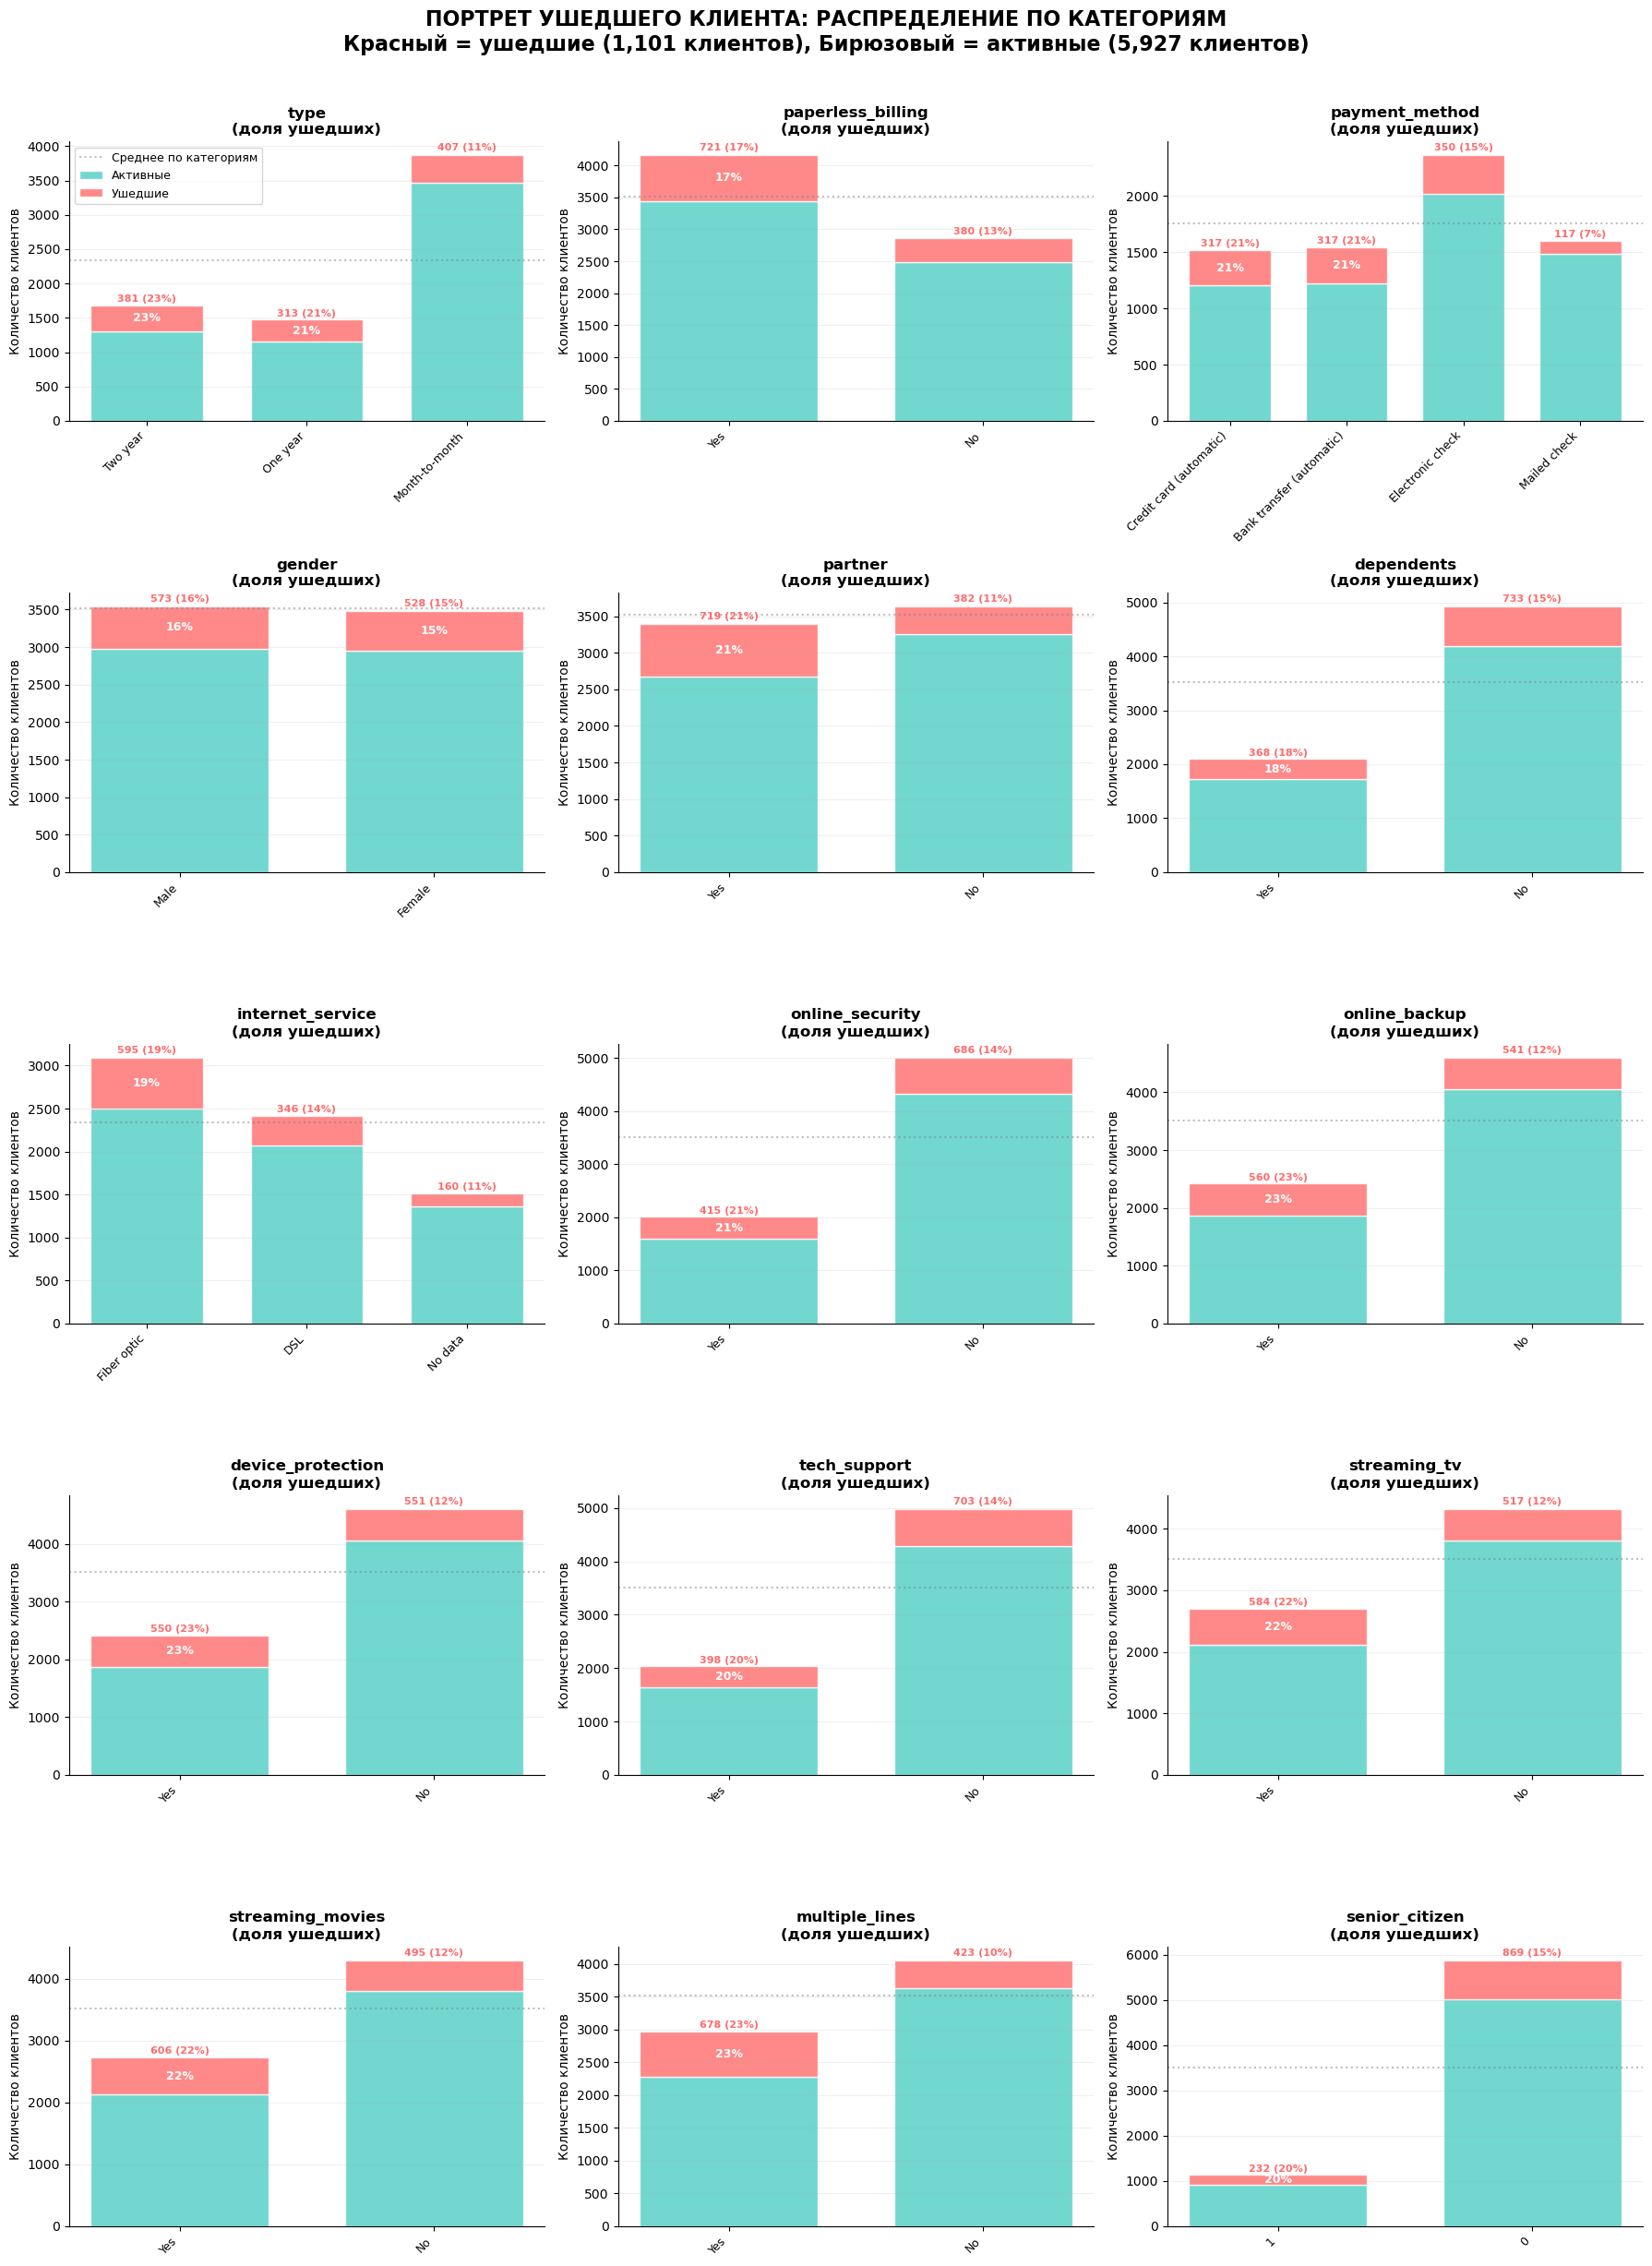


ТОП-5 КАТЕГОРИЙ С ВЫСОКИМ ОТТОКОМ:
1. В признаке online_backup из 2,424 наблюений в категории 'Yes': 23.1% ушедших  
2. В признаке multiple_lines из 2,965 наблюений в категории 'Yes': 22.9% ушедших  
3. В признаке device_protection из 2,417 наблюений в категории 'Yes': 22.8% ушедших  
4. В признаке type из 1,683 наблюений в категории 'Two year': 22.6% ушедших  
5. В признаке streaming_movies из 2,730 наблюений в категории 'Yes': 22.2% ушедших  
6. В признаке streaming_tv из 2,702 наблюений в категории 'Yes': 21.6% ушедших  
7. В признаке partner из 3,391 наблюений в категории 'Yes': 21.2% ушедших  
8. В признаке payment_method из 1,520 наблюений в категории 'Credit card (automatic)': 20.9% ушедших  
9. В признаке online_security из 2,014 наблюений в категории 'Yes': 20.6% ушедших  
10. В признаке senior_citizen из 1,142 наблюений в категории '1': 20.3% ушедших  


In [74]:

total_clients = len(data)
total_churned = data['client_status'].sum()
overall_churn_rate = total_churned / total_clients

print("=" * 60)
print("ОБЩАЯ СТАТИСТИКА:")
print("=" * 60)
print(f"Всего клиентов: {total_clients:,}")
print(f"Ушедших клиентов: {total_churned:,} ({overall_churn_rate:.1%})")
print(f"Активных клиентов: {total_clients - total_churned:,} ({1 - overall_churn_rate:.1%})")
print()

# Создаем фигуру
n_features = len(cat_col)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.ravel() if n_rows * n_cols > 1 else [axes]

# Цветовая схема
ACTIVE_COLOR = '#4ECDC4'  # Бирюзовый для активных
CHURNED_COLOR = '#FF6B6B'  # Красный для ушедших

for i, feature in enumerate(cat_col):
    ax = axes[i]
    
    # Группируем данные для каждого статуса
    churned = data[data['client_status'] == 1][feature].value_counts().sort_index()
    active = data[data['client_status'] == 0][feature].value_counts().sort_index()
    
    # Создем датафрейм для удобства
    df_plot = pd.DataFrame({
        'Ушедшие': churned,
        'Активные': active
    }).fillna(0)
    
    # Сортируем по доле ушедших
    df_plot['Доля ушедших'] = df_plot['Ушедшие'] / (df_plot['Ушедшие'] + df_plot['Активные'])
    df_plot = df_plot.sort_values('Доля ушедших', ascending=False)
    
    x_positions = np.arange(len(df_plot))
    bottom = np.zeros(len(df_plot))
    
    # Сначала активные клиенты
    bars_active = ax.bar(x_positions, df_plot['Активные'], 
                         width=0.7, color=ACTIVE_COLOR, alpha=0.8, 
                         label='Активные', edgecolor='white')
    
    # Затем ушедшие (столбцы сверху)
    bars_churned = ax.bar(x_positions, df_plot['Ушедшие'], 
                          width=0.7, bottom=df_plot['Активные'], 
                          color=CHURNED_COLOR, alpha=0.8, 
                          label='Ушедшие', edgecolor='white')
    # Добавляем аннотации с процентами
    for idx, (active_count, churned_count) in enumerate(zip(df_plot['Активные'], df_plot['Ушедшие'])):
        total = active_count + churned_count
        if total > 0:
            churn_rate = churned_count / total
            # Текст внутри столбца
            if churned_count / total > 0.15:  # Если доля ушедших достаточно большая
                ax.text(idx, active_count + churned_count/2, 
                       f'{churn_rate:.0%}', 
                       ha='center', va='center', 
                       color='white', fontweight='bold', fontsize=9)
            # Текст сверху столбца
            ax.text(idx, active_count + churned_count + total * 0.01, 
                   f'{churned_count:,} ({churn_rate:.0%})', 
                   ha='center', va='bottom', 
                   color=CHURNED_COLOR, fontsize=8, fontweight='bold')
    
    ax.set_title(f'{feature}\n(доля ушедших)', fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Количество клиентов', fontsize=10)
    
    # Устанавливаем подписи по оси X
    ax.set_xticks(x_positions)
    ax.set_xticklabels(df_plot.index.astype(str), rotation=45, ha='right', fontsize=9)
    
    # Добавляем горизонтальную линию общего среднего
    ax.axhline(y=total_clients / len(df_plot), color='gray', linestyle=':', 
               alpha=0.5, label='Среднее по категориям')
    
    # Легенда только для первого графика
    if i == 0:
        ax.legend(loc='upper left', fontsize=9)
    
    # Убираем верхнюю и правую границы
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Сетка только по горизонтали
    ax.grid(True, alpha=0.2, axis='y')

# Скрываем лишние subplots
for i in range(len(cat_col), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('ПОРТРЕТ УШЕДШЕГО КЛИЕНТА: РАСПРЕДЕЛЕНИЕ ПО КАТЕГОРИЯМ\n' +
             f'Красный = ушедшие ({total_churned:,} клиентов), ' +
             f'Бирюзовый = активные ({total_clients - total_churned:,} клиентов)', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# ТОП-10 признаков с наибольшей долей ушедших
print("\n" + "=" * 60)
print("ТОП-5 КАТЕГОРИЙ С ВЫСОКИМ ОТТОКОМ:")
print("=" * 60)
top_churn_features = []

for feature in cat_col:
    grouped = data.groupby(feature)['client_status'].agg(['mean', 'count'])
    # Находим категорию с максимальной долей ушедших
    max_churn_idx = grouped['mean'].idxmax()
    max_churn_rate = grouped.loc[max_churn_idx, 'mean']
    count = grouped.loc[max_churn_idx, 'count']
    top_churn_features.append((feature, max_churn_idx, max_churn_rate, count))

# Сортируем по доле ушедших
top_churn_features.sort(key=lambda x: x[2], reverse=True)

for i, (feature, category, churn_rate, count) in enumerate(top_churn_features[:10]):
    print(f"{i+1}. В признаке {feature} из {count:,} наблюений в категории '{category}': {churn_rate:.1%} ушедших  ")

## Числовые признаки

Здесь я создам функцию для анализа числового признака и применю ее для каждого числового признака

In [130]:
def num_col_analys(col):
    
    data[col].hist(bins = 30)
    plt.title(f'РАСПРЕДЕЛЕНИЕ ПРИЗНАКА {col}')
    plt.xlabel(col)
    plt.ylabel('Кол-во наблюдений, шт')
    plt.show()
    print('='*60)
    print(f'РАСПРЕДЕЛЕНИЕ ПРИЗНАКА {col}')
    print('='*60)
    print(data[col].describe())
    print('='*60)
    print(f'РАСПРЕДЕЛЕНИЕ ПРИЗНАКА {col} среди АКТИВНЫХ')
    print('='*60)
    print(data.query('client_status == 0')[col].describe())
    print('='*60)
    print(f'РАСПРЕДЕЛЕНИЕ ПРИЗНАКА {col} среди УШЕДШИХ')
    print('='*60)
    print(data.query('client_status == 1')[col].describe())
    print(f'Разница средних значений: {data.query('client_status == 0')[col].mean()}')
    fig, axes = plt.subplots(figsize=(10, 8))
    sns.kdeplot(data=data, x=col, hue='client_status', 
                ax=axes, palette={0: ACTIVE_COLOR, 1: CHURNED_COLOR},
                fill=True, alpha=0.5, common_norm=False)
    plt.title(f'Диаграмма плотности признака {col} в разрезе целевого признака(0 - Активный, 1 - Ушел)')
    plt.show()

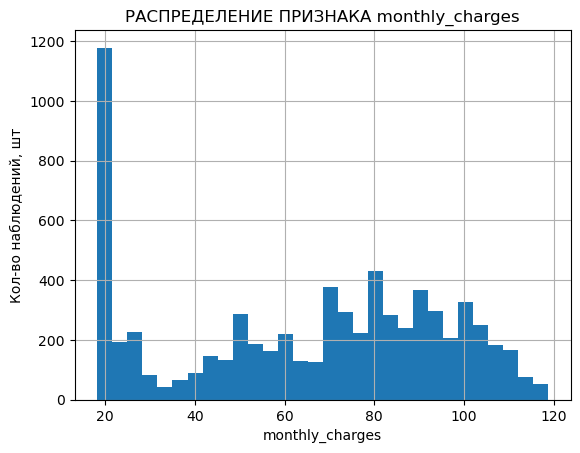

РАСПРЕДЕЛЕНИЕ ПРИЗНАКА monthly_charges
count    7028.000000
mean       64.809555
std        30.075631
min        18.250000
25%        35.650000
50%        70.350000
75%        89.862500
max       118.750000
Name: monthly_charges, dtype: float64
РАСПРЕДЕЛЕНИЕ ПРИЗНАКА monthly_charges среди АКТИВНЫХ
count    5927.000000
mean       62.815151
std        29.830236
min        18.250000
25%        30.200000
50%        69.250000
75%        87.325000
max       118.600000
Name: monthly_charges, dtype: float64
РАСПРЕДЕЛЕНИЕ ПРИЗНАКА monthly_charges среди УШЕДШИХ
count    1101.000000
mean       75.546004
std        29.116213
min        18.400000
25%        56.150000
50%        84.200000
75%        99.500000
max       118.750000
Name: monthly_charges, dtype: float64


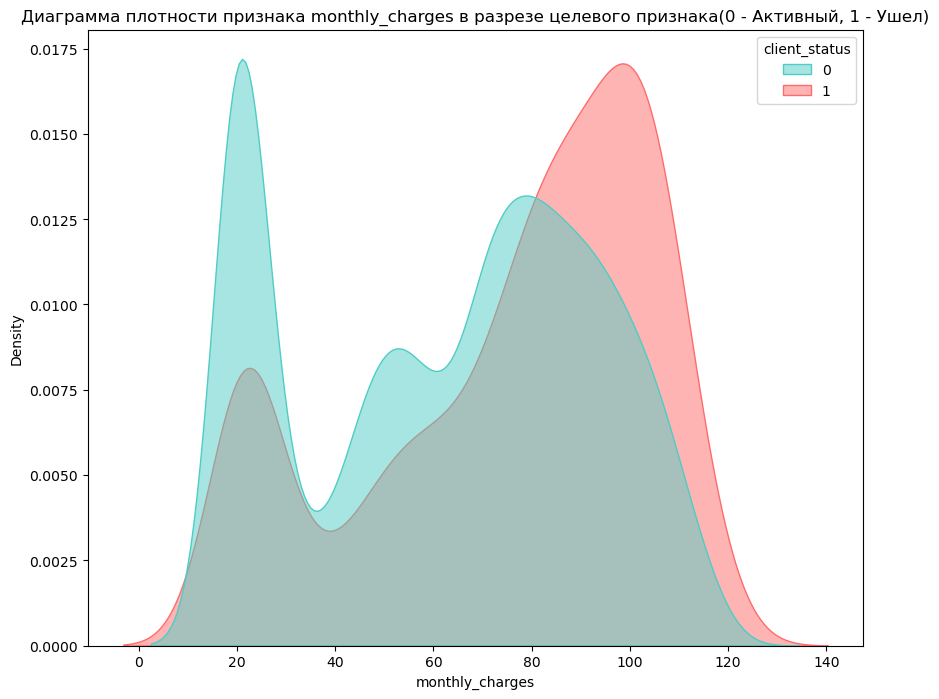

In [131]:
num_col_analys('monthly_charges')

Есть аномальный пик около 20 - скорее всего это самый популярный тариф и большинство клиентов в месяц тратят ровно столько, 

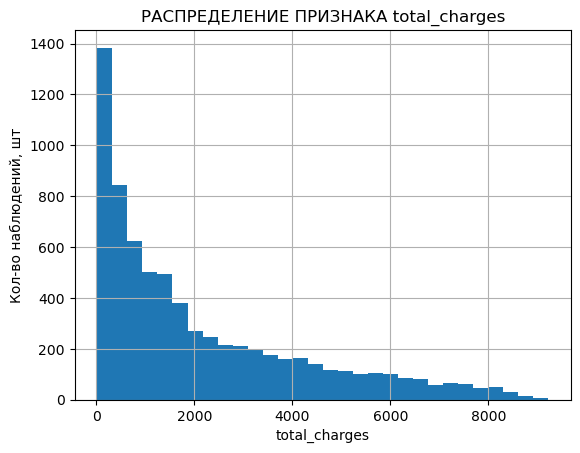

РАСПРЕДЕЛЕНИЕ ПРИЗНАКА total_charges
count    7028.000000
mean     2118.393320
std      2111.787509
min        19.050000
25%       439.987500
50%      1345.275000
75%      3239.317500
max      9221.380000
Name: total_charges, dtype: float64
РАСПРЕДЕЛЕНИЕ ПРИЗНАКА total_charges среди АКТИВНЫХ
count    5927.000000
mean     2071.398999
std      2193.086743
min        19.050000
25%       377.000000
50%      1194.280000
75%      3176.000000
max      9221.380000
Name: total_charges, dtype: float64
РАСПРЕДЕЛЕНИЕ ПРИЗНАКА total_charges среди УШЕДШИХ
count    1101.000000
mean     2371.377275
std      1581.862275
min        77.840000
25%      1048.050000
50%      2139.030000
75%      3404.910000
max      7649.760000
Name: total_charges, dtype: float64


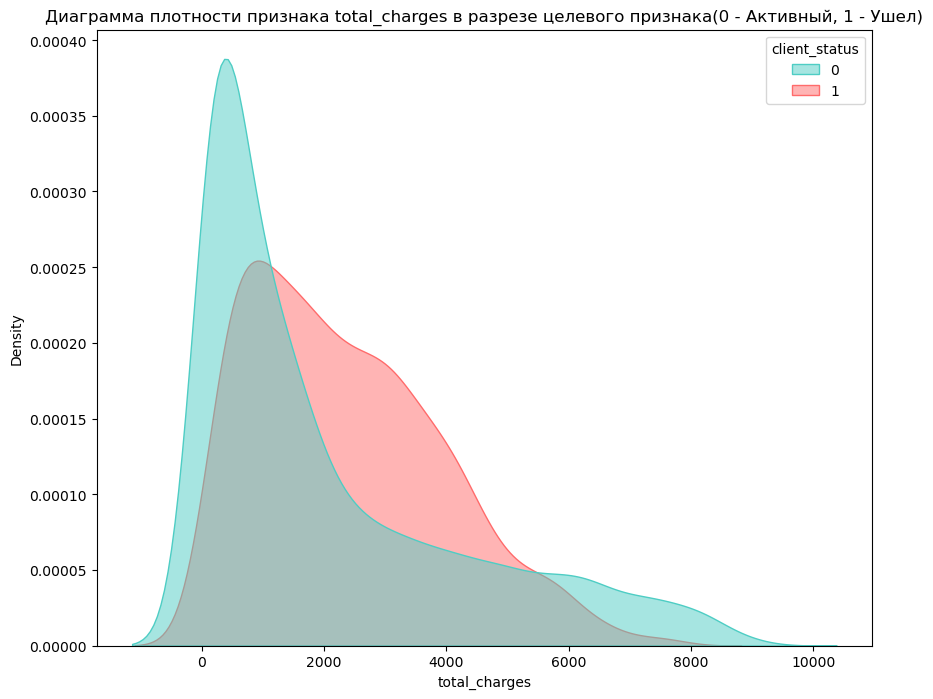

In [132]:
num_col_analys('total_charges')

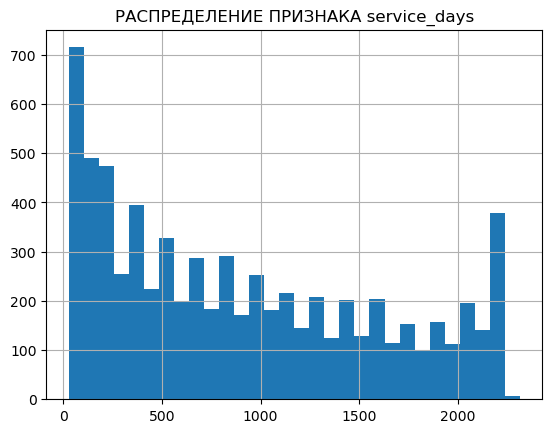

РАСПРЕДЕЛЕНИЕ ПРИЗНАКА service_days
count    7028.000000
mean      899.841207
std       682.428205
min        28.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: service_days, dtype: float64
РАСПРЕДЕЛЕНИЕ ПРИЗНАКА service_days среди АКТИВНЫХ
count    5927.000000
mean      895.193015
std       716.258826
min        31.000000
25%       245.000000
50%       702.000000
75%      1523.000000
max      2314.000000
Name: service_days, dtype: float64
РАСПРЕДЕЛЕНИЕ ПРИЗНАКА service_days среди УШЕДШИХ
count    1101.000000
mean      924.863760
std       458.771309
min        28.000000
25%       577.000000
50%       915.000000
75%      1249.000000
max      2129.000000
Name: service_days, dtype: float64


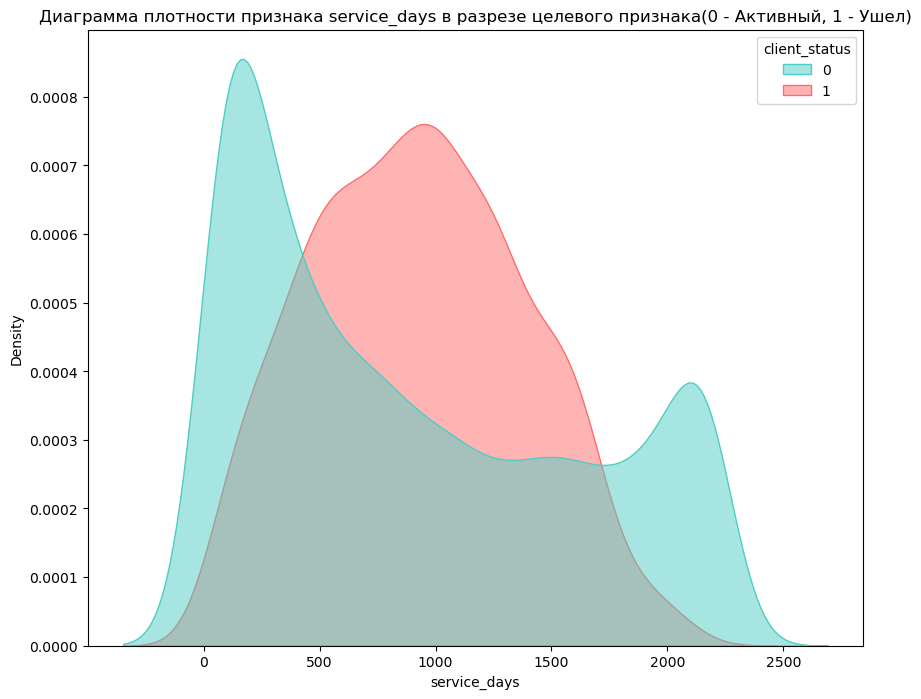

In [129]:
num_col_analys('service_days')

Очень красиво и наглядно вышло! Теряем середину по пользованию сервисом. Очень большой отток клиентов начинается примерно с 500 дня, больше всего отваливается на 1000 день пользования, а после 2000 дней, клиенты становятся лояльны к компании